# Exploring posts on Data science Stack Exchange

For this guided project, we'll be exploring questions and posts on [Data Science Stack Exchange](https://datascience.stackexchange.com/) (DSSE) to determine the best topics that a Data Science educational company should create. We'll be using data from the [Stack Exchange Data Explorer](https://data.stackexchange.com/datascience/query/edit/1542610) (SEDE).

The following tables look promising for determining what the most popular content:
- Posts, which provides info about every post including how many times it has been viewed and favourited
- PostTags, which link Post IDs and Tag IDs
- PostTypes, which contains info about the type of posts
- Tags, which tells us how many times a tag has been used

There are eight different types of posts, with questions and answers making up the bulk of them. As such, we'll focus on questions to understand what topics people are interested in. Assuming that we are doing this in early 2020, we'll also limit our analysis to the posts of 2019, as we want to know what topics have been very popular recently.

## Getting the data

Using the following query, we'll extract selected columns for all questions posted in 2019:

SELECT Id, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE PostTypeId = 1 AND YEAR(CreationDate) = 2019;
ORDER BY Id ASC

Then we'll download the data into a csv file and read it into a dataframe.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
data = pd.read_csv('2019_questions.csv', parse_dates=["CreationDate"])

The first few rows look like this:

In [5]:
data.head(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


## Exploring and cleaning the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


The data spans the period of 23 Jan 2019 to 70 July 2019, and there are >7000 null values in the FavoriteCount column. As FavoriteCount has values when any user favourites the question, we can replace the null values with 0.

In [7]:
data = data.fillna(0)
data['FavoriteCount'] = data['FavoriteCount'].astype(int)

Let's also check what type of data the Tags column contains.

In [8]:
print(data['Tags'].dtype)
print(type(data.iloc[0,4]))

object
<class 'str'>


The Tags are stored as strings, and all the tags for each post are stored in one column. On Stack Exchange, each question can only have a maximum of five tags (source), so we could create five columns called Tag1, Tag2, Tag3, Tag4, and Tag5 and split the tags to fill up these columns.

We'll just keep the as a list for now as splitting them doesn't help with relating one question to another, but we want to transform the strings into something more suitable to use with typical string methods.

In [9]:
# data['Tags'] = [x[1:] for x in data['Tags']]
data['Tags'] = data['Tags'].str.replace('<',',')
data['Tags'] = data['Tags'].str.replace('>','')
# questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
data['Tags'] = data['Tags'].str.split(',')
data.head(5)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[, machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[, machine-learning, regression, linear-regres...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[, python, time-series, forecast, forecasting]",0,0
3,44427,2019-01-23 10:57:09,0,55,"[, machine-learning, scikit-learn, pca]",1,0
4,44428,2019-01-23 11:02:15,0,19,"[, dataset, bigdata, data, speech-to-text]",0,0


## Determining the most popular tags

We'll do find the most populat tags by considering two different popularity proxies: how many times the tag was used, and how many times a question with that tag was viewed.

We could also take into account the score, or whether or not a question is part of someone's favorite questions, but we'll limit the focus of our research to counts and views for now.

### Most used tags

First, we'll find out how many times each tag was used and view the top 20 tags.

In [10]:
tag_counts = pd.Series(sum([item for item in data['Tags']], [])).value_counts()
tag_counts = pd.DataFrame(tag_counts)
tag_counts.rename(columns={0: "Count"}, inplace=True)
tag_counts.head(20)


,Count
,8839
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493


In [11]:
# tag_count = dict()

# for tags in data["Tags"]:
#     for tag in tags:
#         if tag in tag_count:
#             tag_count[tag] += 1
#         else:
#             tag_count[tag] = 1

The threshold of 20 is somewhat arbitrary but the popularity of the tags rapidly declines, so looking at these tags should be enough to help us with our goal. Let's visualize the data.

In [12]:
most_used = tag_counts.iloc[0:20,:]

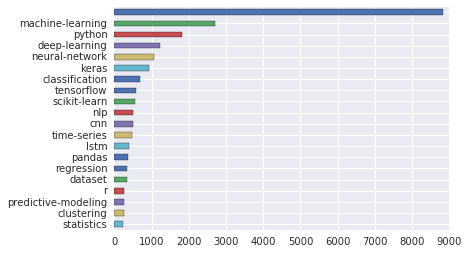

In [13]:
chart = most_used['Count'].plot.barh()
chart.invert_yaxis()
plt.show()

Some tags like python, dataset, and r are very general and are unlikely to be useful. Before we investigate the tags a little deeper, let's repeat the same process for views.

### Most viewed tags

In [14]:
# Getting the view counts of each tag
view_count = dict()

for index, row in data.iterrows():
    for tag in row['Tags']:
        if tag in view_count:
            view_count[tag] += row['ViewCount']
        else: 
            view_count[tag] = row['ViewCount']

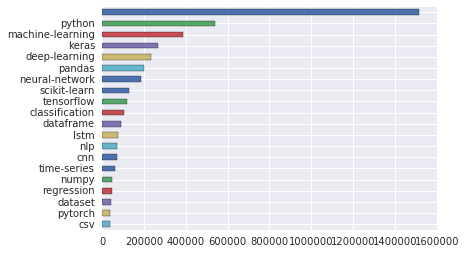

In [15]:
# Transforming the view counts into a dictionary and getting the top 20 tags
view_counts = pd.DataFrame.from_dict(view_count, orient='index')
view_counts.rename(columns={0: 'ViewCount'}, inplace=True)
view_counts.sort_values(by='ViewCount', axis=0, ascending=False, inplace=True)

most_viewed = view_counts.iloc[0:20,:]

# Visualising the results
chart2 = most_viewed['ViewCount'].plot.barh()
chart2.invert_yaxis()
plt.show()

Some of the most viewed tags are likewise too general to be useful e.g. python. We can also see that most top tags are present in both dataframes. Let's see what tags are most used but not most viewed.

In [16]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_used

,Count,ViewCount
,8839,1516313.0
machine-learning,2693,388499.0
python,1814,537585.0
deep-learning,1220,233628.0
neural-network,1055,185367.0
keras,935,268608.0
classification,685,104457.0
tensorflow,584,121369.0
scikit-learn,540,128110.0
nlp,493,71382.0


Let's also see what tags are most viewed but not most used.

In [17]:
pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)


,Count,ViewCount
,8839.0,1516313
python,1814.0,537585
machine-learning,2693.0,388499
keras,935.0,268608
deep-learning,1220.0,233628
pandas,354.0,201787
neural-network,1055.0,185367
scikit-learn,540.0,128110
tensorflow,584.0,121369
classification,685.0,104457


The tags present in most_used and not present in most_viewed are:

- machine-learning-model
- statistics
- predictive-modeling
- r

The tags present in most_viewed but not in most_used are:

- csv
- pytorch
- dataframe

Some tags also stand out as being related. For example, python is related to pandas, as we can find both pythons and pandas in the same country — or better yet, because pandas is a Python library. So by writing about pandas, we can actually simultaneously tackle two tags.

## Looking at relations between tags

To find out how tags are related to each other, we'll look at how often the most used tags appear in pairs. 

In [40]:
# Get tags list
tags_list = list(tag_counts.index)
# tags_list = tags_list[1:]
# Create a dataframe with the tags as rows and columns where all values are 0
relations = pd.DataFrame(index=tags_list, columns=tags_list)
relations = relations.fillna(0)


Now we will increment the values in the DataFrame when the pairs of tags occur together, so that we end up with a dataframe summarising how many times each of the most-used pairs occur together. We will select a subset of the dataframe consisting of the most used tags to make it easier to handle.

In [41]:
for tags in data["Tags"]:
    relations.loc[tags, tags] += 1
relations

most_used_relations = relations.loc[most_used.index, most_used.index]


Let's add some colors to make it easier to talk about the dataframe

In [48]:
# most_used_relations.drop(columns='', inplace=True)
# most_used_relations.drop(labels='', axis=0, inplace=True)

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

most_used_relations.style.apply(style_cells, axis=None)

,machine-learning,python,deep-learning,neural-network,keras,classification,tensorflow,scikit-learn,nlp,cnn,time-series,lstm,pandas,regression,dataset,r,predictive-modeling,clustering,statistics
machine-learning,2693,499,429,366,195,259,106,188,113,124,131,71,62,119,99,63,123,61,89
python,499,1814,160,137,280,98,167,235,71,62,105,61,244,59,53,24,35,45,35
deep-learning,429,160,1220,305,247,59,136,16,72,160,44,103,1,21,32,5,32,2,12
neural-network,366,137,305,1055,235,65,108,24,24,118,33,69,1,42,20,9,13,8,11
keras,195,280,247,235,935,58,256,34,23,116,51,133,3,31,13,10,11,0,3
classification,259,98,59,65,58,685,20,47,35,20,25,20,3,34,28,10,27,12,19
tensorflow,106,167,136,108,256,20,584,15,11,57,9,43,3,9,9,1,6,0,0
scikit-learn,188,235,16,24,34,47,15,540,12,0,12,2,37,37,9,1,12,24,6
nlp,113,71,72,24,23,35,11,12,493,7,0,19,3,2,11,4,1,9,3
cnn,124,62,160,118,116,20,57,0,7,489,8,24,1,6,11,2,6,0,1


The cells highlighted in yellow tell us that time-series was used together with r 22 times. The values in blue tell us how many times each of the tags was used. We saw earlier that machine-learning was used 2693 times and we confirm it in this dataframe.

To make the data easier to understand, we'll create a heatmap. But first we'll get rid of the values in blue, otherwise the colors will be too skewed.

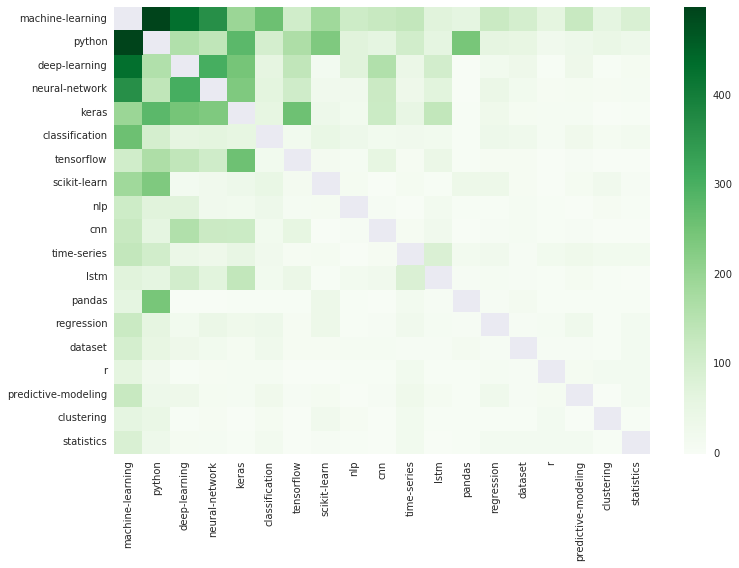

In [49]:
for i in range(most_used_relations.shape[0]):
    most_used_relations.iloc[i,i] = pd.np.NaN
    
plt.figure(figsize=(12,8))
sns.heatmap(most_used_relations, cmap="Greens", annot=False)

The most used tags also seem to have the strongest relationships, but this could simply be because each of these tags is used a lot, and so end up being used together a lot regardless of the relation between them.

Another shortcoming of this attempt is that it only looks at relations between pairs of tags and not between multiple groups of tags. 

We would use other emthods such as association rules and statistical independence to test the relationships between tags, but we won't go into that for now.


If we focus on just the most used and most viewed tags, we can see that they are often the same. The top 10 tags of each have these tags in common: python, machine-learning, deep-learning, neural-network, keras, tensorflow, classification, scikit-learn.

Keras, tensorflow and scikit-learn are all used to implement deep learning (a type of neural network and a subset of machine learning) in python. Classification is a type of machine learning. It would appear that the most popular questions tend to be related to deep learning in python.

## Verifying deep learning trend

Before making our recommendation, we want to check if deep learning is a fad or if interest in it has lasted over time. 

We use the following query to extract all the questions ever asked on DSSE, their dates and tags, to track the interst in deep learning across time.

SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;

Then we'll read the data into a dataframe and transform the data in the same way that we did for the 2019 data.

In [125]:
all_questions = pd.read_csv('all_questions.csv', parse_dates=['CreationDate'])
all_questions['Tags'] = [x[1:] for x in all_questions['Tags']]
all_questions['Tags'] = all_questions['Tags'].str.replace('<',',')
all_questions['Tags'] = all_questions['Tags'].str.replace('>','')
# # questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
all_questions['Tags'] = all_questions['Tags'].str.split(',')
all_questions.tail(5)

,Id,CreationDate,Tags
21571,36971,2018-08-15 14:19:01,"[statistics, data]"
21572,36974,2018-08-15 14:40:27,"[machine-learning, neural-network, classifier]"
21573,36975,2018-08-15 14:53:43,"[machine-learning, classification]"
21574,36979,2018-08-14 19:31:43,"[tensorflow, python]"
21575,36985,2018-08-15 17:01:29,"[python, deep-learning, tensorflow]"


From the most used tags, we can see that the following tags are related to deep learning: ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]. As such, we'll define deep learning questions as those that use any of these tags.

The data runs from to 13 May 2014 to 19 Jan 2020, which should be alright for our analysis.

In [127]:
# Filter data by year
all_questions['CreationYear'] = pd.DatetimeIndex(all_questions['CreationDate']).year
questions_subset = all_questions
# questions_subset = all_questions[all_questions['CreationYear'] > 2016]
# Get total number of questions
num_questions = questions_subset.shape[0]
print('Total number of questions: ')
print(num_questions)


Total number of questions: 
21576


In [128]:
question_count = 0
dl_tags = ["lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning"]

# questions_subset['DL'] = questions_subset['Tags'].apply(lambda x: )
for tags in questions_subset["Tags"]:
    for tag in tags:
        if tag in dl_tags:
            question_count += 1
        else:
            question_count = question_count
print('Deep learning questions:')
print(question_count)

Deep learning questions:
11539


In [129]:
print('Percentage of deep learning questions:')
print(question_count/num_questions*100)

Percentage of deep learning questions:
53.480719317760474


We can see that from 2016 to early 2020, about 60% of questions were related to deep learning. Let's see how the popularity of deep learning might have changed over time by grouping the occurences by month.

In [130]:
# Creating a column that stores year and month info
questions_subset['CreationMonth'] = pd.DatetimeIndex(questions_subset['CreationDate']).month
questions_subset['yearmonth'] = questions_subset["CreationYear"].astype(str) + questions_subset["CreationMonth"].astype(str)


In [131]:
# Creating a function and column that indicates whether a question is about deep learning

def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

questions_subset["DeepLearning"] = questions_subset["Tags"].apply(class_deep_learning)
# questions_subset


In [137]:
# Getting a dataframe with the number of Deep Learning questions and total questions per month

monthly_dl = questions_subset.groupby(['yearmonth']).sum()['DeepLearning']
monthly_dl = pd.DataFrame(monthly_dl).reset_index()

monthly_total = questions_subset.groupby(['yearmonth']).size()
monthly_total = pd.DataFrame(monthly_total).reset_index()
monthly_total.columns=['yearmonth','total questions']

monthly = monthly_dl.merge(monthly_total,how='outer', on='yearmonth',)
monthly['%_dl'] = round(monthly['DeepLearning'] / monthly['total questions']*100,2)
monthly['year'] = monthly['yearmonth'].str[:4].astype(int)
monthly['month'] = monthly['yearmonth'].str[4:].astype(int)
monthly = monthly.sort_values(by=['year','month'], ascending=True)
monthly


,yearmonth,DeepLearning,total questions,%_dl,year,month
3,20145,2,58,3.45,2014,5
4,20146,7,99,7.07,2014,6
5,20147,7,76,9.21,2014,7
6,20148,5,65,7.69,2014,8
7,20149,1,48,2.08,2014,9
0,201410,7,71,9.86,2014,10
1,201411,6,64,9.38,2014,11
2,201412,8,81,9.88,2014,12
8,20151,4,63,6.35,2015,1
12,20152,6,73,8.22,2015,2


In [133]:
print('mean monthly percentage of Deep Learning questions:')
print(monthly['%_dl'].mean())

mean monthly percentage of Deep Learning questions:
28.56


Now let's plot the data so we can see if there are any trends.

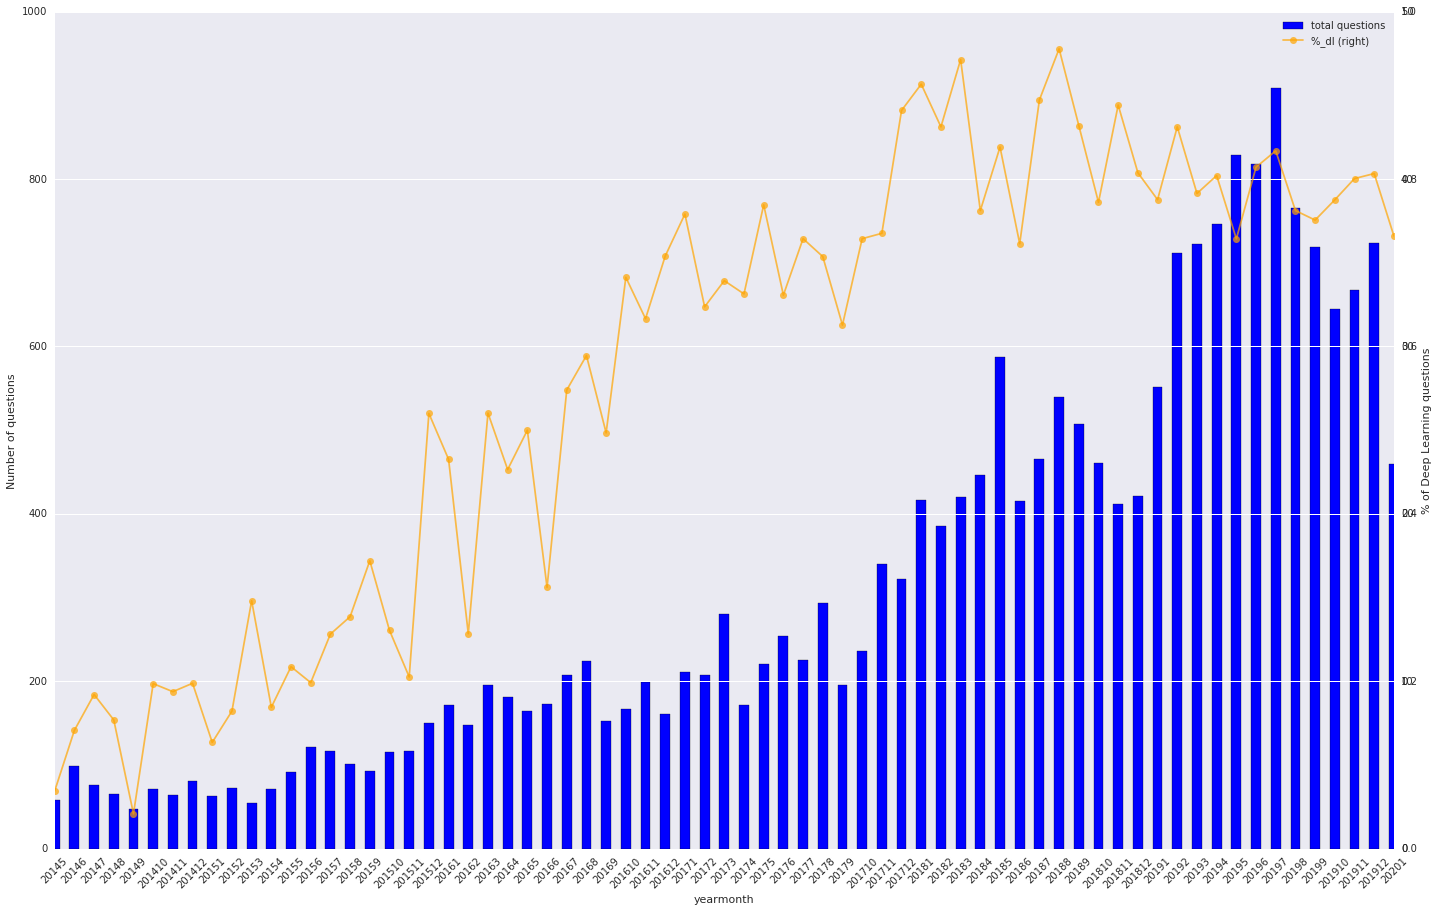

In [173]:
fig, ax1 = plt.subplots(figsize=(24, 15))
ax2 = ax1.twinx()
monthly.plot(x='yearmonth',y='total questions',kind='bar', ax=ax1,
            color="blue", grid=False)
monthly.plot(x='yearmonth',y='%_dl',kind='line', marker="o",color="orange", ax=ax1, secondary_y=True, alpha=0.7, rot=45)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax1.set_ylabel("Number of questions")
ax2.set_ylabel("% of Deep Learning questions")

Based on the graph, deep learning questions have had a high-growth trend since the start of DSSE. It looks like it is plateauing, but it is not decreasing, so we would recommend proposing create deep learning content.

Other possible analyses:
- What other content can we recommend that isn't as popular? You can try using association rules to find strong relations between tags.
- What other popularity features could we include in our analysis? Perhaps scores and favourite counts?
- We focused on DSSE. How could we use other related sites to help us with our goal?
- How can we leverage other sites to determine what non-data-science content to write about? For example, is there some mathematical field that leads to more questions than others?